In [1]:
from janus_wraper import *
import torch
from transformers import AutoModelForCausalLM
from Janus.janus.models import MultiModalityCausalLM, VLChatProcessor
from Janus.janus.utils.io import load_pil_images

# specify the path to the model
model_path = "/projectnb/cs598/projects/cool_proj/model"
device = 'cuda'

chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)

gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
gpt = gpt.to(torch.bfloat16).to(device).eval()





Python version is above 3.10, patching the collections module.


/projectnb/cs598/projects/cool_proj/.venv/lib/python3.11/site-packages/transformers/models/auto/image_processing_auto.py:592: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


Python version is above 3.10, patching the collections module.


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Some kwargs in processor config are unused and will not have any effect: num_image_tokens, image_tag, sft_format, ad

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
text_prompt = 'Where is this image from?'

# # Load the image from a file
image = Image.open("img.jpg")
# tokenizer = vl_chat_processor.tokenizer

# Call the unified function for multimodal understanding (text output)
result = janus_pro_generate(
    chat_processor,
    gpt,
    device=device,
    input_text=text_prompt,
    input_image=image,
    output_mode="text",
)
print(result)


This image appears to be from a parade or military event. The tanks are lined up on a street, and there is a person walking alongside them. The specific location is not clear from the image alone, but it could be a city in a country with a military parade tradition.


In [5]:
text_prompt = 'make this image a meme'

# # Load the image from a file
image = Image.open("img.jpg")
# tokenizer = vl_chat_processor.tokenizer

# Call the unified function for multimodal understanding (text output)
result = janus_pro_generate(
    chat_processor,
    gpt,
    device=device,
    input_text=text_prompt,
    input_image=image,
    output_mode="image",
    guidance=5,
    t2i_temperature=1.0,
    num_images=2,
    # width=192,
    # height=192,
)


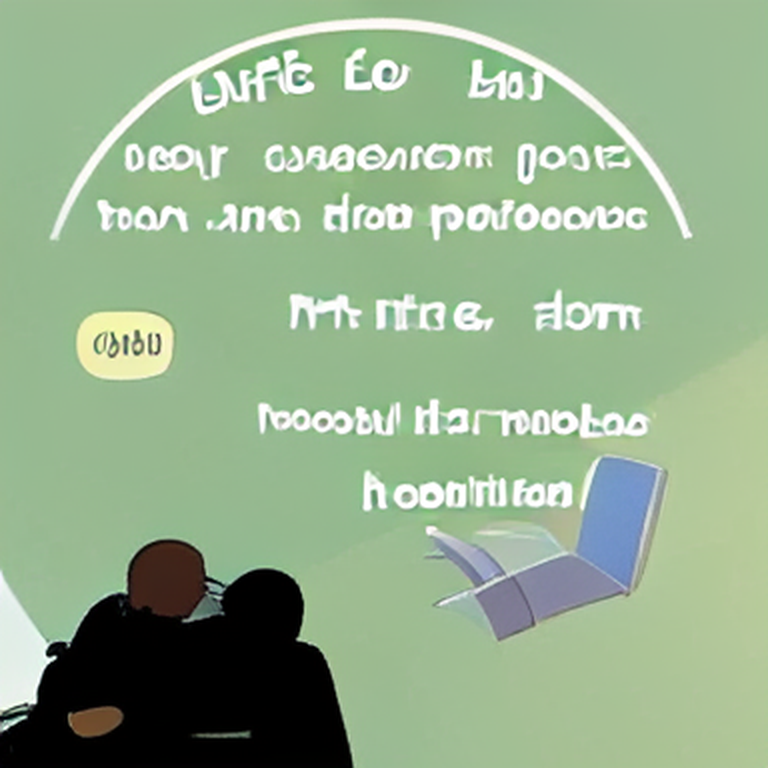

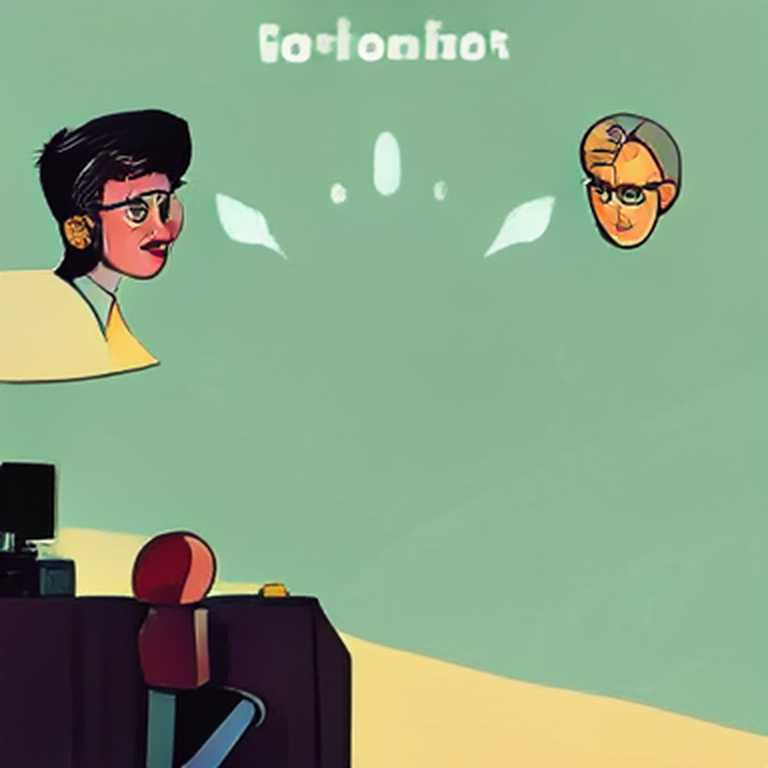

Generated Text Response:


In [6]:
# Save generated images to disk.
for idx, img in enumerate(result):
    display(img)


# Print the generated text response
print("Generated Text Response:")

In [5]:
import re
from datasets import load_dataset
import io

dataset = load_dataset("array/SAT", batch_size=128//4)

# dataset should have a training and validation key
print(dataset.keys())
example = dataset['vlaidation'][:10] # example 10th item
print(example.keys())
for i in range(len(example['image_bytes'])):
    display(example['image_bytes'][i][0])
    print(example['question'][i])
    print(example['answers'][i])
    print(example['correct_answer'][i])

#again not working

Generating train split: 0 examples [00:00, ? examples/s]

DatasetGenerationError: An error occurred while generating the dataset

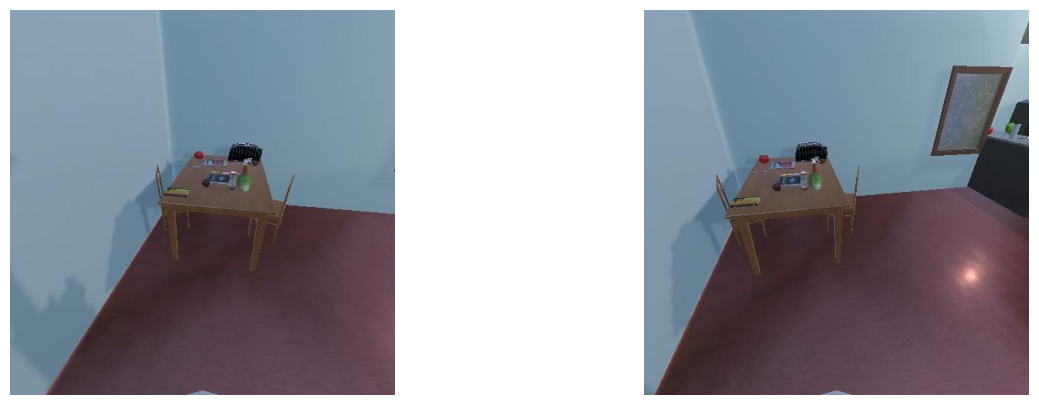

The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
['rotated right' 'rotated left']
rotated right


In [36]:
import pandas as pd
import io
from PIL import Image

df = pd.read_parquet('/projectnb/cs598/projects/cool_proj/Spatial-Reasoning/dataset', engine='pyarrow')#change path here

example = df.iloc[10]
images = [Image.open(io.BytesIO(im_bytes)) for im_bytes in example['image_bytes']]

import matplotlib.pyplot as plt

# Display images
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

if len(images) == 1:
    axes.imshow(images[0])
    axes.axis("off")
else:
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis("off")

plt.show()

question = example['question']
print(question)
answer_choices = example['answers']
print(answer_choices)
correct_answer = example['correct_answer']
print(correct_answer)

# Function to convert bytes to BytesIO objects
def convert_to_bytesio(image_bytes):
    return np.asarray([Image.open(io.BytesIO(im_bytes)) for im_bytes in image_bytes][0], dtype=np.uint8)

    # if isinstance(image_bytes, ):
    #     # If it's a list of images, convert each image
    #     return [Image.open(io.BytesIO(im_bytes)) for im_bytes in image_bytes]
    # else:
    #     print(type(image_bytes))
    #     # If it's a single image
    #     return Image.open(io.BytesIO(image_bytes))


# Apply the conversion to the entire column
df['image_bytes'] = df['image_bytes'].apply(convert_to_bytesio)


In [ ]:
from tqdm import tqdm

def extract_ans(pred_text):
    matches = re.findall(r"\[(.*?)\]", pred_text)
    
    return matches

def predict_all(dataset, vl_chat_processor, vl_gpt, device='cuda'):
    predictions = []

    for i in tqdm(range(len(dataset['image_bytes']))):
        input_image = dataset['image_bytes'][i]
        question = dataset['question'][i]
        answer_choices = dataset['answers'][i]
        
        input_prompt = f'''
                        Instructions: You have to answer the following question using the given options.
                                      Enclose your answer in [].
                                      For example, if the answer is yes, it must be formatted like [yes].

                        Question: {question}

                        Image: {input_image}

                        Options: {answer_choices}                        

                       '''

        prediction_text = janus_pro_generate(
            vl_chat_processor=vl_chat_processor,
            vl_gpt=vl_gpt,
            input_text=input_prompt,
            # answer_choices=answer_choices,
            input_image=input_image,
            device=device,
            output_mode="text",
            temperature=0.1,
            top_p=0.95,
            seed=42
        )
        prediction = extract_ans(prediction_text)
        predictions.append({
            "question": question,
            "answers": answer_choices,
            "prediction": prediction,
            "correct_answer": dataset['correct_answer'][i]
        })

        print(f"Question: {question}")
        print(f"Choices: {answer_choices}")
        print(f"Predicted Answer: {prediction}")
        print(f"Correct Answer: {dataset['correct_answer'][i]}")
        print("-" * 50)

    return predictions

predictions = predict_all(df, chat_processor, gpt)
#made a prediction function but might need some fixing @Surya

  0%|          | 1/4001 [00:00<1:00:34,  1.10it/s]

Question: Were any of the objects in the initial frame that you can still see in the second frame moved from their original positions?
Choices: ['Chair was moved left and towards the camera in the first frame'
 'Chair was moved right and away from the camera in the first frame']
Predicted Answer: []
Correct Answer: Chair was moved left and towards the camera in the first frame
--------------------------------------------------


  0%|          | 2/4001 [00:01<1:05:03,  1.02it/s]

Question: The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
Choices: ['did not move' 'rotated left']
Predicted Answer: ['rotated left']
Correct Answer: did not move
--------------------------------------------------


  0%|          | 3/4001 [00:03<1:15:25,  1.13s/it]

Question: I need to go to Chair (near the mark 7 in the image). Which direction should I turn to face the object?
Choices: ['look straight' 'left by 40 degrees']
Predicted Answer: []
Correct Answer: look straight
--------------------------------------------------


  0%|          | 4/4001 [00:03<58:10,  1.15it/s]  

Question: If I turn left by 40 degrees, will I be facing away from Chair (near the mark 7 in the image)?
Choices: ['yes' 'no']
Predicted Answer: []
Correct Answer: yes
--------------------------------------------------


  0%|          | 5/4001 [00:04<50:18,  1.32it/s]

Question: If I look straight, will I be facing away from Chair (near the mark 7 in the image)?
Choices: ['no' 'yes']
Predicted Answer: ['yes']
Correct Answer: no
--------------------------------------------------


  0%|          | 6/4001 [00:04<45:32,  1.46it/s]

Question: Were any of the objects in the initial frame that you can still see in the second frame moved from their original positions?
Choices: ['no objects moved'
 'Pot was moved right and towards the camera in the first frame']
Predicted Answer: []
Correct Answer: no objects moved
--------------------------------------------------


  0%|          | 7/4001 [00:05<51:30,  1.29it/s]

Question: The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
Choices: ['rotated left' 'did not move']
Predicted Answer: []
Correct Answer: rotated left
--------------------------------------------------


  0%|          | 8/4001 [00:06<46:44,  1.42it/s]

Question: Were any of the objects in the initial frame that you can still see in the second frame moved from their original positions?
Choices: ['no objects moved'
 'sofa was moved left and away from the camera in the first frame']
Predicted Answer: []
Correct Answer: no objects moved
--------------------------------------------------


  0%|          | 9/4001 [00:07<52:10,  1.28it/s]

Question: The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
Choices: ['rotated left' 'did not move']
Predicted Answer: []
Correct Answer: rotated left
--------------------------------------------------


  0%|          | 10/4001 [00:07<47:14,  1.41it/s]

Question: Were any of the objects in the initial frame that you can still see in the second frame moved from their original positions?
Choices: ['no objects moved'
 'Chair was moved right and away from the camera in the first frame']
Predicted Answer: []
Correct Answer: no objects moved
--------------------------------------------------


  0%|          | 11/4001 [00:08<51:00,  1.30it/s]

Question: The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
Choices: ['rotated right' 'rotated left']
Predicted Answer: []
Correct Answer: rotated right
--------------------------------------------------


  0%|          | 12/4001 [00:09<46:40,  1.42it/s]

Question: Were any of the objects in the initial frame that you can still see in the second frame moved from their original positions?
Choices: ['HousePlant was moved right and towards the camera in the first frame'
 'HousePlant was moved left and away from the camera in the first frame']
Predicted Answer: ['yes']
Correct Answer: HousePlant was moved right and towards the camera in the first frame
--------------------------------------------------


  0%|          | 13/4001 [00:10<47:19,  1.40it/s]

Question: The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
Choices: ['did not move' 'rotated left and moved forward']
Predicted Answer: []
Correct Answer: did not move
--------------------------------------------------


  0%|          | 14/4001 [00:10<45:50,  1.45it/s]

Question: I need to go to HousePlant (near the mark 2 in the image). Which direction should I turn to face the object?
Choices: ['left by 36 degrees' 'look straight']
Predicted Answer: []
Correct Answer: left by 36 degrees
--------------------------------------------------


  0%|          | 15/4001 [00:11<42:49,  1.55it/s]

Question: If I look straight, will I be facing away from HousePlant (near the mark 2 in the image)?
Choices: ['yes' 'no']
Predicted Answer: ['no']
Correct Answer: yes
--------------------------------------------------


  0%|          | 16/4001 [00:11<40:42,  1.63it/s]

Question: If I turn left by 36 degrees, will I be facing away from HousePlant (near the mark 2 in the image)?
Choices: ['no' 'yes']
Predicted Answer: ['yes']
Correct Answer: no
--------------------------------------------------


  0%|          | 17/4001 [00:12<39:51,  1.67it/s]

Question: Were any of the objects in the initial frame that you can still see in the second frame moved from their original positions?
Choices: ['no objects moved'
 'table was moved left and towards the camera in the first frame']
Predicted Answer: []
Correct Answer: no objects moved
--------------------------------------------------


  0%|          | 18/4001 [00:12<41:13,  1.61it/s]

Question: The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
Choices: ['rotated right and moved forward' 'did not move']
Predicted Answer: []
Correct Answer: rotated right and moved forward
--------------------------------------------------


  0%|          | 19/4001 [00:13<38:17,  1.73it/s]

Question: Were any of the objects in the initial frame that you can still see in the second frame moved from their original positions?
Choices: ['tied black garbage bag was moved left and towards the camera in the first frame'
 'tied black garbage bag was moved right and away from the camera in the first frame']
Predicted Answer: []
Correct Answer: tied black garbage bag was moved left and towards the camera in the first frame
--------------------------------------------------


  0%|          | 20/4001 [00:14<45:56,  1.44it/s]

Question: The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
Choices: ['rotated right' 'did not move']
Predicted Answer: []
Correct Answer: rotated right
--------------------------------------------------


  1%|          | 21/4001 [00:14<43:03,  1.54it/s]

Question: Were any of the objects in the initial frame that you can still see in the second frame moved from their original positions?
Choices: ['Chair was moved right and towards the camera in the first frame'
 'Chair was moved left and away from the camera in the first frame']
Predicted Answer: ['no']
Correct Answer: Chair was moved right and towards the camera in the first frame
--------------------------------------------------


  1%|          | 22/4001 [00:15<45:24,  1.46it/s]

Question: The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
Choices: ['rotated right and moved forward' 'did not move']
Predicted Answer: []
Correct Answer: rotated right and moved forward
--------------------------------------------------


  1%|          | 23/4001 [00:16<44:27,  1.49it/s]

Question: I need to go to Bed (near the mark 2 in the image). Which direction should I turn to face the object?
Choices: ['right by 29 degrees' 'look straight']
Predicted Answer: []
Correct Answer: right by 29 degrees
--------------------------------------------------


  1%|          | 24/4001 [00:16<41:55,  1.58it/s]

Question: If I look straight, will I be facing away from Bed (near the mark 2 in the image)?
Choices: ['yes' 'no']
Predicted Answer: ['no']
Correct Answer: yes
--------------------------------------------------


  1%|          | 25/4001 [00:17<40:10,  1.65it/s]

Question: If I turn right by 29 degrees, will I be facing away from Bed (near the mark 2 in the image)?
Choices: ['no' 'yes']
Predicted Answer: ['yes']
Correct Answer: no
--------------------------------------------------


  1%|          | 26/4001 [00:18<43:24,  1.53it/s]

Question: I need to go to Laptop (near the mark 1 in the image). Which direction should I turn to face the object?
Choices: ['right by 44 degrees' 'left by 44 degrees']
Predicted Answer: []
Correct Answer: right by 44 degrees
--------------------------------------------------


  1%|          | 27/4001 [00:18<41:06,  1.61it/s]

Question: If I turn left by 44 degrees, will I be facing away from Laptop (near the mark 1 in the image)?
Choices: ['yes' 'no']
Predicted Answer: ['yes']
Correct Answer: yes
--------------------------------------------------


  1%|          | 28/4001 [00:19<39:34,  1.67it/s]

Question: If I turn right by 44 degrees, will I be facing away from Laptop (near the mark 1 in the image)?
Choices: ['no' 'yes']
Predicted Answer: ['yes']
Correct Answer: no
--------------------------------------------------


  1%|          | 29/4001 [00:19<40:27,  1.64it/s]

Question: I need to go to Chair (near the mark 5 in the image). Which direction should I turn to face the object?
Choices: ['look straight' 'left by 40 degrees']
Predicted Answer: []
Correct Answer: look straight
--------------------------------------------------


  1%|          | 30/4001 [00:20<39:02,  1.70it/s]

Question: If I turn left by 40 degrees, will I be facing away from Chair (near the mark 5 in the image)?
Choices: ['yes' 'no']
Predicted Answer: ['yes']
Correct Answer: yes
--------------------------------------------------


  1%|          | 31/4001 [00:21<38:03,  1.74it/s]

Question: If I look straight, will I be facing away from Chair (near the mark 5 in the image)?
Choices: ['no' 'yes']
Predicted Answer: ['yes']
Correct Answer: no
--------------------------------------------------


  1%|          | 32/4001 [00:21<37:29,  1.76it/s]

Question: Were any of the objects in the initial frame that you can still see in the second frame moved from their original positions?
Choices: ['no objects moved'
 'blue translucent garbage bag was moved right and towards the camera in the first frame']
Predicted Answer: []
Correct Answer: no objects moved
--------------------------------------------------


  1%|          | 33/4001 [00:22<40:57,  1.61it/s]

Question: The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
Choices: ['rotated left' 'rotated right']
Predicted Answer: []
Correct Answer: rotated left
--------------------------------------------------


  1%|          | 34/4001 [00:22<39:27,  1.68it/s]

Question: Were any of the objects in the initial frame that you can still see in the second frame moved from their original positions?
Choices: ['Chair was moved left and towards the camera in the first frame'
 'Chair was moved right and away from the camera in the first frame']
Predicted Answer: ['no']
Correct Answer: Chair was moved left and towards the camera in the first frame
--------------------------------------------------


  1%|          | 35/4001 [00:23<46:02,  1.44it/s]

Question: The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
Choices: ['did not move' 'rotated right and moved forward']
Predicted Answer: []
Correct Answer: did not move
--------------------------------------------------


  1%|          | 36/4001 [00:24<44:51,  1.47it/s]

Question: I need to go to Chair (near the mark 4 in the image). Which direction should I turn to face the object?
Choices: ['left by 12 degrees' 'look straight']
Predicted Answer: []
Correct Answer: left by 12 degrees
--------------------------------------------------


  1%|          | 37/4001 [00:24<42:06,  1.57it/s]

Question: If I look straight, will I be facing away from Chair (near the mark 4 in the image)?
Choices: ['yes' 'no']
Predicted Answer: ['yes']
Correct Answer: yes
--------------------------------------------------


  1%|          | 38/4001 [00:25<40:10,  1.64it/s]

Question: If I turn left by 12 degrees, will I be facing away from Chair (near the mark 4 in the image)?
Choices: ['no' 'yes']
Predicted Answer: ['yes']
Correct Answer: no
--------------------------------------------------


  1%|          | 39/4001 [00:26<38:49,  1.70it/s]

Question: Were any of the objects in the initial frame that you can still see in the second frame moved from their original positions?
Choices: ['no objects moved'
 'table was moved right and away from the camera in the first frame']
Predicted Answer: []
Correct Answer: no objects moved
--------------------------------------------------


  1%|          | 40/4001 [00:26<44:20,  1.49it/s]

Question: The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
Choices: ['rotated left and moved forward' 'did not move']
Predicted Answer: []
Correct Answer: rotated left and moved forward
--------------------------------------------------


  1%|          | 41/4001 [00:28<56:29,  1.17it/s]

Question: I need to go to Dresser (near the mark 1 in the image). Which direction should I turn to face the object?
Choices: ['left by 58 degrees' 'look straight']
Predicted Answer: []
Correct Answer: left by 58 degrees
--------------------------------------------------


  1%|          | 42/4001 [00:28<49:01,  1.35it/s]

Question: If I look straight, will I be facing away from Dresser (near the mark 1 in the image)?
Choices: ['yes' 'no']
Predicted Answer: []
Correct Answer: yes
--------------------------------------------------


  1%|          | 43/4001 [00:29<43:46,  1.51it/s]

Question: If I turn left by 58 degrees, will I be facing away from Dresser (near the mark 1 in the image)?
Choices: ['no' 'yes']
Predicted Answer: []
Correct Answer: no
--------------------------------------------------


  1%|          | 44/4001 [00:29<41:22,  1.59it/s]

Question: Were any of the objects in the initial frame that you can still see in the second frame moved from their original positions?
Choices: ['no objects moved'
 'HousePlant was moved right and towards the camera in the first frame']
Predicted Answer: []
Correct Answer: no objects moved
--------------------------------------------------


  1%|          | 45/4001 [00:30<47:56,  1.38it/s]

Question: The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
Choices: ['rotated right' 'did not move']
Predicted Answer: []
Correct Answer: rotated right
--------------------------------------------------


  1%|          | 46/4001 [00:31<58:57,  1.12it/s]

Question: I need to go to ShelvingUnit (near the mark 5 in the image). Which direction should I turn to face the object?
Choices: ['left by 51 degrees' 'right by 51 degrees']
Predicted Answer: []
Correct Answer: left by 51 degrees
--------------------------------------------------


  1%|          | 47/4001 [00:32<51:59,  1.27it/s]

Question: If I turn right by 51 degrees, will I be facing away from ShelvingUnit (near the mark 5 in the image)?
Choices: ['yes' 'no']
Predicted Answer: ['yes']
Correct Answer: yes
--------------------------------------------------


  1%|          | 48/4001 [00:33<47:13,  1.40it/s]

Question: If I turn left by 51 degrees, will I be facing away from ShelvingUnit (near the mark 5 in the image)?
Choices: ['no' 'yes']
Predicted Answer: ['yes']
Correct Answer: no
--------------------------------------------------


  1%|          | 49/4001 [00:33<43:48,  1.50it/s]

Question: Were any of the objects in the initial frame that you can still see in the second frame moved from their original positions?
Choices: ['HousePlant was moved right and towards the camera in the first frame'
 'HousePlant was moved left and away from the camera in the first frame']
Predicted Answer: ['yes']
Correct Answer: HousePlant was moved right and towards the camera in the first frame
--------------------------------------------------


  1%|          | 50/4001 [00:34<49:02,  1.34it/s]

Question: The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
Choices: ['did not move' 'rotated right and moved forward']
Predicted Answer: []
Correct Answer: did not move
--------------------------------------------------


  1%|▏         | 51/4001 [00:35<46:57,  1.40it/s]

Question: I need to go to HousePlant (near the mark 1 in the image). Which direction should I turn to face the object?
Choices: ['right by 16 degrees' 'look straight']
Predicted Answer: []
Correct Answer: right by 16 degrees
--------------------------------------------------


  1%|▏         | 52/4001 [00:35<43:36,  1.51it/s]

Question: If I look straight, will I be facing away from HousePlant (near the mark 1 in the image)?
Choices: ['yes' 'no']
Predicted Answer: ['no']
Correct Answer: yes
--------------------------------------------------


  1%|▏         | 53/4001 [00:36<41:17,  1.59it/s]

Question: If I turn right by 16 degrees, will I be facing away from HousePlant (near the mark 1 in the image)?
Choices: ['no' 'yes']
Predicted Answer: ['yes']
Correct Answer: no
--------------------------------------------------


  1%|▏         | 54/4001 [00:36<40:14,  1.63it/s]

Question: Were any of the objects in the initial frame that you can still see in the second frame moved from their original positions?
Choices: ['no objects moved'
 'Bed was moved left and away from the camera in the first frame']
Predicted Answer: []
Correct Answer: no objects moved
--------------------------------------------------


  1%|▏         | 55/4001 [00:37<43:53,  1.50it/s]

Question: The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
Choices: ['rotated right and moved forward' 'rotated left and moved forward']
Predicted Answer: []
Correct Answer: rotated right and moved forward
--------------------------------------------------


  1%|▏         | 56/4001 [00:38<55:20,  1.19it/s]

Question: I need to go to Chair (near the mark 2 in the image). Which direction should I turn to face the object?
Choices: ['left by 23 degrees' 'look straight']
Predicted Answer: []
Correct Answer: left by 23 degrees
--------------------------------------------------


  1%|▏         | 57/4001 [00:39<49:20,  1.33it/s]

Question: If I look straight, will I be facing away from Chair (near the mark 2 in the image)?
Choices: ['yes' 'no']
Predicted Answer: ['no']
Correct Answer: yes
--------------------------------------------------


  1%|▏         | 58/4001 [00:39<43:56,  1.50it/s]

Question: If I turn left by 23 degrees, will I be facing away from Chair (near the mark 2 in the image)?
Choices: ['no' 'yes']
Predicted Answer: []
Correct Answer: no
--------------------------------------------------


  1%|▏         | 59/4001 [00:40<49:04,  1.34it/s]

Question: I need to go to Bed (near the mark 12 in the image). Which direction should I turn to face the object?
Choices: ['right by 27 degrees' 'look straight']
Predicted Answer: []
Correct Answer: right by 27 degrees
--------------------------------------------------


  1%|▏         | 60/4001 [00:41<45:00,  1.46it/s]

Question: If I look straight, will I be facing away from Bed (near the mark 12 in the image)?
Choices: ['yes' 'no']
Predicted Answer: ['no']
Correct Answer: yes
--------------------------------------------------


  2%|▏         | 61/4001 [00:41<42:15,  1.55it/s]

Question: If I turn right by 27 degrees, will I be facing away from Bed (near the mark 12 in the image)?
Choices: ['no' 'yes']
Predicted Answer: ['yes']
Correct Answer: no
--------------------------------------------------


  2%|▏         | 62/4001 [00:42<47:50,  1.37it/s]

Question: I need to go to Window (near the mark 3 in the image). Which direction should I turn to face the object?
Choices: ['right by 46 degrees' 'look straight']
Predicted Answer: []
Correct Answer: right by 46 degrees
--------------------------------------------------


  2%|▏         | 63/4001 [00:43<44:06,  1.49it/s]

Question: If I look straight, will I be facing away from Window (near the mark 3 in the image)?
Choices: ['yes' 'no']
Predicted Answer: ['no']
Correct Answer: yes
--------------------------------------------------


  2%|▏         | 64/4001 [00:43<41:41,  1.57it/s]

Question: If I turn right by 46 degrees, will I be facing away from Window (near the mark 3 in the image)?
Choices: ['no' 'yes']
Predicted Answer: ['yes']
Correct Answer: no
--------------------------------------------------


  2%|▏         | 65/4001 [00:44<39:44,  1.65it/s]

Question: Were any of the objects in the initial frame that you can still see in the second frame moved from their original positions?
Choices: ['no objects moved'
 'cup was moved right and away from the camera in the first frame']
Predicted Answer: []
Correct Answer: no objects moved
--------------------------------------------------


  2%|▏         | 66/4001 [00:45<46:33,  1.41it/s]

Question: The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
Choices: ['rotated right' 'did not move']
Predicted Answer: []
Correct Answer: rotated right
--------------------------------------------------


  2%|▏         | 67/4001 [00:45<43:12,  1.52it/s]

Question: Were any of the objects in the initial frame that you can still see in the second frame moved from their original positions?
Choices: ['no objects moved'
 'Chair was moved right and away from the camera in the first frame']
Predicted Answer: []
Correct Answer: no objects moved
--------------------------------------------------


  2%|▏         | 68/4001 [00:46<49:07,  1.33it/s]

Question: The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
Choices: ['rotated left' 'did not move']
Predicted Answer: []
Correct Answer: rotated left
--------------------------------------------------


  2%|▏         | 69/4001 [00:47<45:03,  1.45it/s]

Question: Were any of the objects in the initial frame that you can still see in the second frame moved from their original positions?
Choices: ['Chair was moved left and towards the camera in the first frame'
 'Chair was moved right and away from the camera in the first frame']
Predicted Answer: ['no']
Correct Answer: Chair was moved left and towards the camera in the first frame
--------------------------------------------------


  2%|▏         | 70/4001 [00:48<48:29,  1.35it/s]

Question: The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
Choices: ['rotated left' 'rotated right']
Predicted Answer: []
Correct Answer: rotated left
--------------------------------------------------


  2%|▏         | 71/4001 [00:49<57:48,  1.13it/s]

Question: I need to go to Chair (near the mark 1 in the image). Which direction should I turn to face the object?
Choices: ['left by 59 degrees' 'right by 59 degrees']
Predicted Answer: []
Correct Answer: left by 59 degrees
--------------------------------------------------


  2%|▏         | 72/4001 [00:50<51:08,  1.28it/s]

Question: If I turn right by 59 degrees, will I be facing away from Chair (near the mark 1 in the image)?
Choices: ['yes' 'no']
Predicted Answer: ['yes']
Correct Answer: yes
--------------------------------------------------


  2%|▏         | 73/4001 [00:50<46:24,  1.41it/s]

Question: If I turn left by 59 degrees, will I be facing away from Chair (near the mark 1 in the image)?
Choices: ['no' 'yes']
Predicted Answer: ['yes']
Correct Answer: no
--------------------------------------------------


  2%|▏         | 74/4001 [00:51<43:05,  1.52it/s]

Question: Were any of the objects in the initial frame that you can still see in the second frame moved from their original positions?
Choices: ['Chair was moved right and towards the camera in the first frame'
 'Chair was moved left and away from the camera in the first frame']
Predicted Answer: ['no']
Correct Answer: Chair was moved right and towards the camera in the first frame
--------------------------------------------------


  2%|▏         | 75/4001 [00:52<50:14,  1.30it/s]

Question: The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
Choices: ['rotated left and moved forward' 'did not move']
Predicted Answer: []
Correct Answer: rotated left and moved forward
--------------------------------------------------


  2%|▏         | 76/4001 [00:53<59:36,  1.10it/s]

Question: I need to go to Window (near the mark 18 in the image). Which direction should I turn to face the object?
Choices: ['left by 29 degrees' 'look straight']
Predicted Answer: []
Correct Answer: left by 29 degrees
--------------------------------------------------


  2%|▏         | 77/4001 [00:53<52:19,  1.25it/s]

Question: If I look straight, will I be facing away from Window (near the mark 18 in the image)?
Choices: ['yes' 'no']
Predicted Answer: ['no']
Correct Answer: yes
--------------------------------------------------


  2%|▏         | 78/4001 [00:54<47:14,  1.38it/s]

Question: If I turn left by 29 degrees, will I be facing away from Window (near the mark 18 in the image)?
Choices: ['no' 'yes']
Predicted Answer: ['yes']
Correct Answer: no
--------------------------------------------------


  2%|▏         | 79/4001 [00:55<45:31,  1.44it/s]

Question: I need to go to gray secure safe (near the mark 2 in the image). Which direction should I turn to face the object?
Choices: ['left by 51 degrees' 'look straight']
Predicted Answer: []
Correct Answer: left by 51 degrees
--------------------------------------------------


  2%|▏         | 80/4001 [00:55<42:26,  1.54it/s]

Question: If I look straight, will I be facing away from gray secure safe (near the mark 2 in the image)?
Choices: ['yes' 'no']
Predicted Answer: ['no']
Correct Answer: yes
--------------------------------------------------


  2%|▏         | 81/4001 [00:56<40:16,  1.62it/s]

Question: If I turn left by 51 degrees, will I be facing away from gray secure safe (near the mark 2 in the image)?
Choices: ['no' 'yes']
Predicted Answer: ['yes']
Correct Answer: no
--------------------------------------------------


  2%|▏         | 82/4001 [00:56<43:07,  1.51it/s]

Question: I need to go to Chair (near the mark 4 in the image). Which direction should I turn to face the object?
Choices: ['right by 20 degrees' 'left by 20 degrees']
Predicted Answer: []
Correct Answer: right by 20 degrees
--------------------------------------------------


  2%|▏         | 83/4001 [00:57<40:47,  1.60it/s]

Question: If I turn left by 20 degrees, will I be facing away from Chair (near the mark 4 in the image)?
Choices: ['yes' 'no']
Predicted Answer: ['no']
Correct Answer: yes
--------------------------------------------------


  2%|▏         | 84/4001 [00:58<39:04,  1.67it/s]

Question: If I turn right by 20 degrees, will I be facing away from Chair (near the mark 4 in the image)?
Choices: ['no' 'yes']
Predicted Answer: ['yes']
Correct Answer: no
--------------------------------------------------


  2%|▏         | 85/4001 [00:58<37:21,  1.75it/s]

Question: Were any of the objects in the initial frame that you can still see in the second frame moved from their original positions?
Choices: ['tied black garbage bag was moved right and towards the camera in the first frame'
 'tied black garbage bag was moved left and away from the camera in the first frame']
Predicted Answer: []
Correct Answer: tied black garbage bag was moved right and towards the camera in the first frame
--------------------------------------------------


  2%|▏         | 86/4001 [00:59<43:37,  1.50it/s]

Question: The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
Choices: ['rotated right' 'rotated left']
Predicted Answer: []
Correct Answer: rotated right
--------------------------------------------------


  2%|▏         | 87/4001 [01:00<55:02,  1.19it/s]

Question: I need to go to tied black garbage bag (near the mark 3 in the image). Which direction should I turn to face the object?
Choices: ['left by 22 degrees' 'look straight']
Predicted Answer: []
Correct Answer: left by 22 degrees
--------------------------------------------------


  2%|▏         | 88/4001 [01:01<49:30,  1.32it/s]

Question: If I look straight, will I be facing away from tied black garbage bag (near the mark 3 in the image)?
Choices: ['yes' 'no']
Predicted Answer: ['no']
Correct Answer: yes
--------------------------------------------------


  2%|▏         | 89/4001 [01:01<45:20,  1.44it/s]

Question: If I turn left by 22 degrees, will I be facing away from tied black garbage bag (near the mark 3 in the image)?
Choices: ['no' 'yes']
Predicted Answer: ['yes']
Correct Answer: no
--------------------------------------------------


  2%|▏         | 90/4001 [01:02<49:52,  1.31it/s]

Question: Were any of the objects in the initial frame that you can still see in the second frame moved from their original positions?
Choices: ['SideTable was moved right and towards the camera in the first frame'
 'SideTable was moved left and away from the camera in the first frame']
Predicted Answer: ['SideTable was moved right and towards the camera in the first frame']
Correct Answer: SideTable was moved right and towards the camera in the first frame
--------------------------------------------------


  2%|▏         | 91/4001 [01:03<52:59,  1.23it/s]

Question: The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
Choices: ['did not move' 'rotated left and moved forward']
Predicted Answer: []
Correct Answer: did not move
--------------------------------------------------


  2%|▏         | 92/4001 [01:04<55:14,  1.18it/s]

Question: I need to go to SideTable (near the mark 2 in the image). Which direction should I turn to face the object?
Choices: ['left by 38 degrees' 'right by 38 degrees']
Predicted Answer: []
Correct Answer: left by 38 degrees
--------------------------------------------------


  2%|▏         | 93/4001 [01:05<49:19,  1.32it/s]

Question: If I turn right by 38 degrees, will I be facing away from SideTable (near the mark 2 in the image)?
Choices: ['yes' 'no']
Predicted Answer: ['no']
Correct Answer: yes
--------------------------------------------------


  2%|▏         | 94/4001 [01:05<45:06,  1.44it/s]

In [ ]:
correct_num = 0
total = len(predictions)

for i in predictions:
    
    if i['correct_answer'] in i['prediction']: correct_num += 1 # used 'in' cause its a list.
                                                                # If the model is just predicting one ans during testing this, we can just make it one.                        


